In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import os
import imageio
import cv2
import shutil
from zipfile import ZipFile
import shutil
from keras.applications import resnet
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,Conv2D,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf 

In [2]:
!nvidia-smi

Wed Apr 12 12:40:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0               12W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Dataset Exploration

In [3]:
if os.path.exists('./data_resampled') and (os.path.exists('./data_resampled/train') or os.path.exists('./data_resampled/test')):
    shutil.rmtree('./data_resampled')

if (os.path.exists('./data/train') and os.path.exists('./data/test'))==False:    
    print('Unzipping')
    with ZipFile('./data_archive.zip', 'r') as zObject:
        zObject.extractall(path='./data/')
    print('Unzipping Done')

In [3]:
train_path ='./data/train/'
test_path ='./data/test/'

categories = os.listdir(train_path)

df = pd.DataFrame(categories,columns=['Emotions'])
train_count = []
test_count = []

for path in [train_path,test_path]: 
    for cat in categories:
        
        current_path = os.listdir(path+cat)
        if path == train_path:
            train_count.append(len(current_path))
            
        elif path == test_path:
            test_count.append(len(current_path))
            
df['Train_images_count'] = train_count
df['Test_images_count'] = test_count
display(df)

,Emotions,Train_images_count,Test_images_count
0,angry,3995,958
1,disgust,436,111
2,fear,4097,1024
3,happy,7215,1774
4,neutral,4965,1233
5,sad,4830,1247
6,surprise,3171,831


Emotion:  angry
(48, 48, 3)


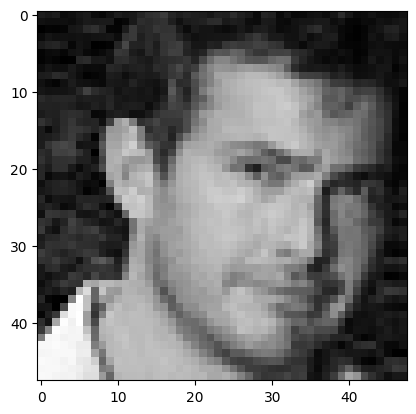

Emotion:  disgust
(48, 48, 3)


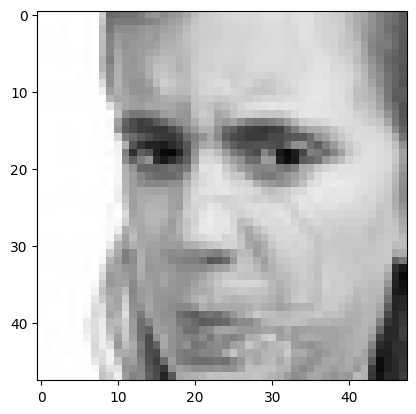

Emotion:  fear
(48, 48, 3)


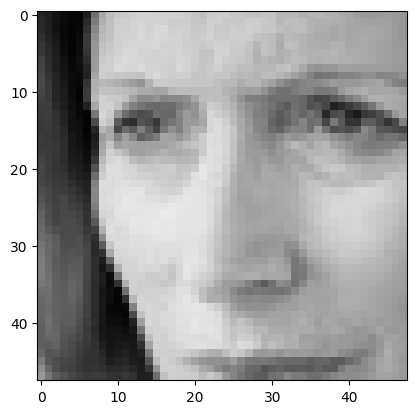

Emotion:  happy
(48, 48, 3)


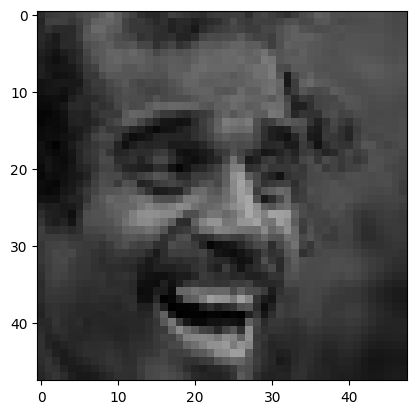

Emotion:  neutral
(48, 48, 3)


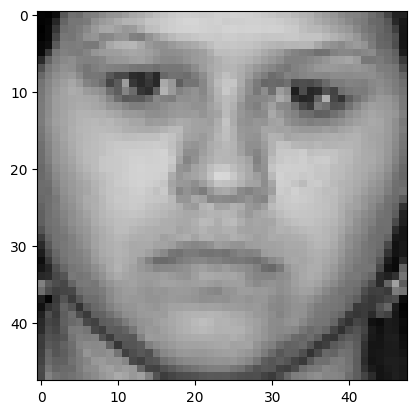

Emotion:  sad
(48, 48, 3)


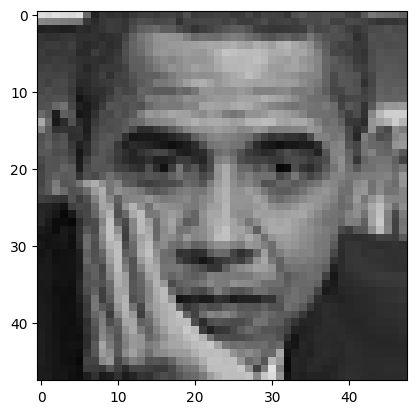

Emotion:  surprise
(48, 48, 3)


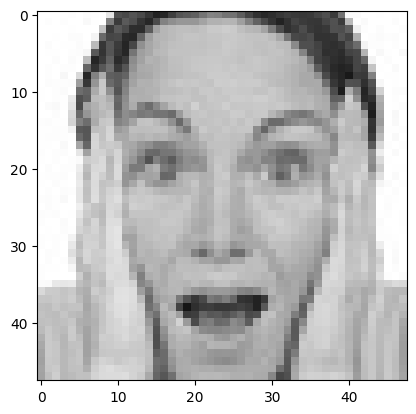

In [4]:
# Viewing Sample images from train set

for cat in categories:
    print("Emotion: ",cat)
    image = cv2.imread(train_path+cat+'/'+(os.listdir(train_path+cat)[1]))
    print(image.shape)
    plt.imshow(image)
    plt.show()

Emotion:  angry


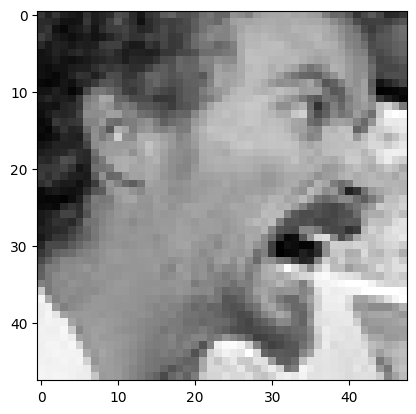

Emotion:  disgust


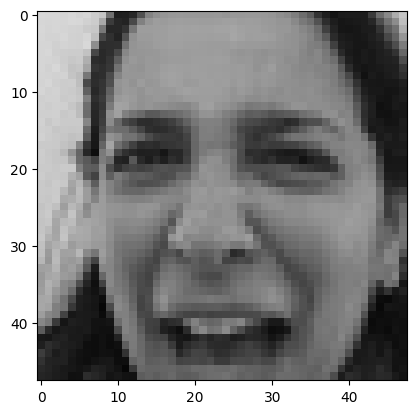

Emotion:  fear


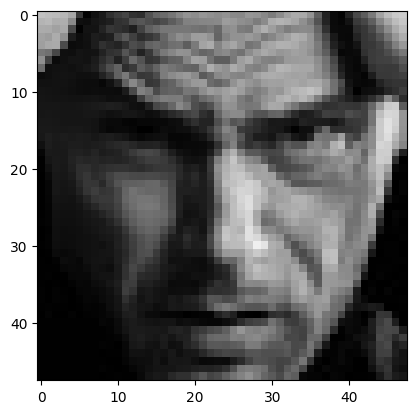

Emotion:  happy


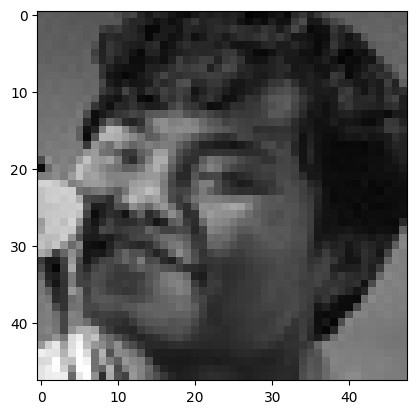

Emotion:  neutral


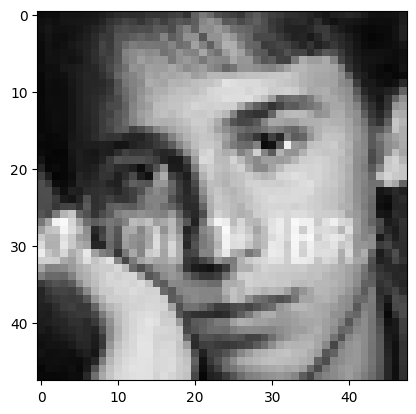

Emotion:  sad


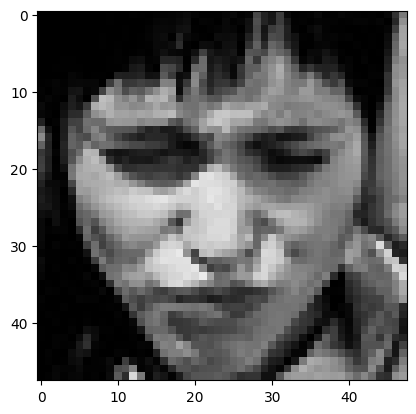

Emotion:  surprise


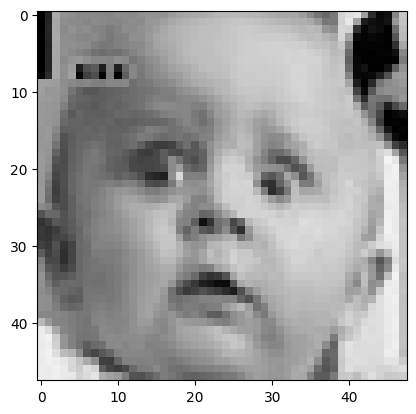

In [5]:
# Viewing Sample images from test set

for cat in categories:
    print("Emotion: ",cat)
    image = cv2.imread(test_path+cat+'/'+(os.listdir(test_path+cat)[1]))
    plt.imshow(image)
    plt.show()

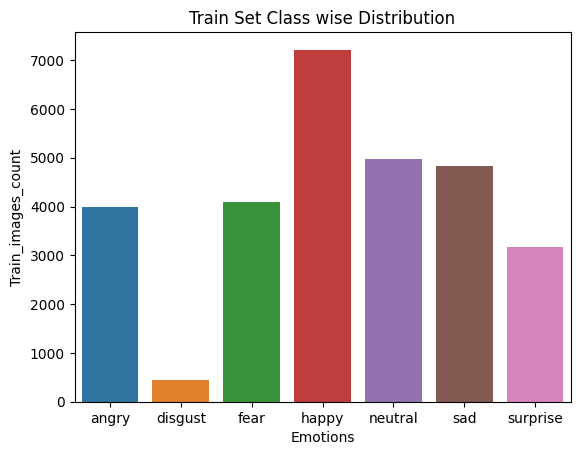

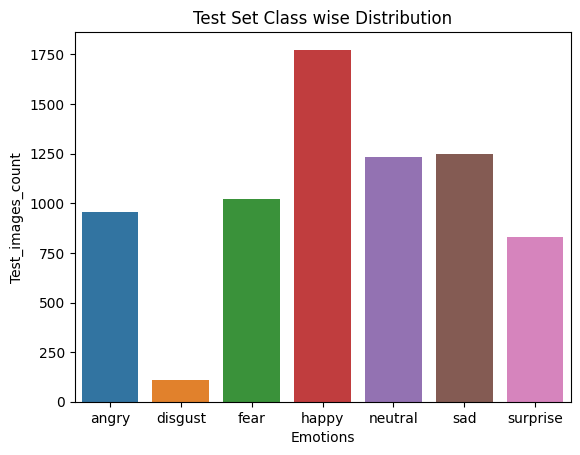

In [6]:
# Class wise distribution

import matplotlib
sns.barplot(x=df.Emotions,y=df.Train_images_count)
plt.title('Train Set Class wise Distribution')
plt.show()

plt.title('Test Set Class wise Distribution')
sns.barplot(x=df.Emotions,y=df.Test_images_count)
plt.show()

In [7]:
# There is a high class imbalance in Disgust alone
# Now solve the class imbalance using over sampling.

### Elimination of data imbalance

In [8]:
# Checking the count of each class
df

,Emotions,Train_images_count,Test_images_count
0,angry,3995,958
1,disgust,436,111
2,fear,4097,1024
3,happy,7215,1774
4,neutral,4965,1233
5,sad,4830,1247
6,surprise,3171,831


In [9]:
# getting the average of count other than disgust
avg = sum(df[df.Emotions!='disgust'].Train_images_count)/(len(df)-1)
avg

4712.166666666667

In [10]:
# Getting the ratio of the avg and disgust count
float(avg/df[df.Emotions=='disgust'].Train_images_count)

10.807721712538227

In [12]:
# As per the above statement the disgust has 10 times lesser image data than the average of other class data
# So lets oversample the data of this class atleast 8 times

shutil.copytree('./data/','./data_resampled/')

resample_train_path = './data_resampled/train/disgust/'
resample_test_path = './data_resampled/test/disgust/'

print('Resampling Train Data')
for a in range(1,4):
    files_list = sorted(os.listdir(resample_train_path))
    for file in range(0, len(files_list)):
        files = files_list[file] 
        shutil.copyfile(resample_train_path+files, resample_train_path+str(a)+files)  

print('Resampling Test Data')
        
for a in range(1,4):
    files_list = sorted(os.listdir(resample_test_path))
    for file in range(0, len(files_list)):
        files = files_list[file] 
        shutil.copyfile(resample_test_path+files, resample_test_path+str(a)+files)  

Resampling Train Data
Resampling Test Data


### Dataset visualization now after resampling

In [11]:
train_path ='./data_resampled/train/'
test_path ='./data_resampled/test/'

categories = os.listdir(train_path)

df_resampled = pd.DataFrame(categories,columns=['Emotions'])
train_count = []
test_count = []

for path in [train_path,test_path]: 
    for cat in categories:
        
        current_path = os.listdir(path+cat)
        if path == train_path:
            train_count.append(len(current_path))
            
        elif path == test_path:
            test_count.append(len(current_path))
            
df_resampled['Train_images_count'] = train_count
df_resampled['Test_images_count'] = test_count
display(df_resampled)

,Emotions,Train_images_count,Test_images_count
0,angry,3995,958
1,disgust,3488,888
2,fear,4097,1024
3,happy,7215,1774
4,neutral,4965,1233
5,sad,4830,1247
6,surprise,3171,831


### Function - Image data generator

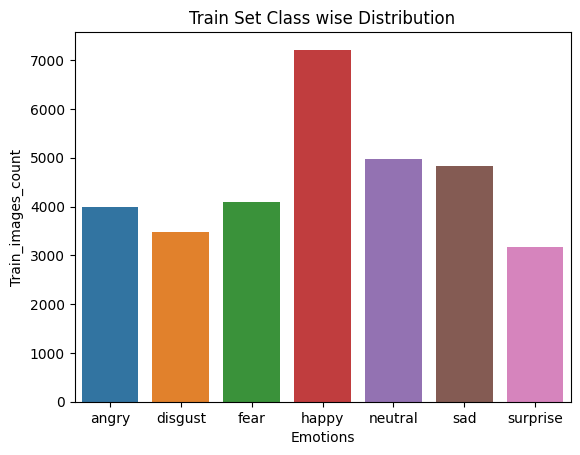

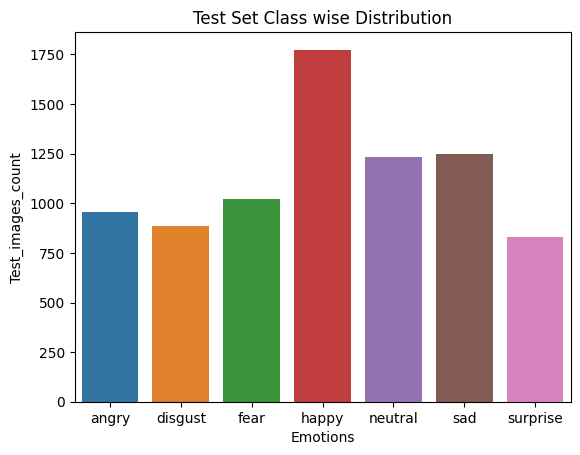

In [12]:
# Class wise distribution

sns.barplot(x=df_resampled.Emotions,y=df_resampled.Train_images_count)
plt.title('Train Set Class wise Distribution')
plt.show()

plt.title('Test Set Class wise Distribution')
sns.barplot(x=df_resampled.Emotions,y=df_resampled.Test_images_count)
plt.show()

### Image data generator

In [13]:
def image_generator(img_size,batch_size,color_mode,resampling=False):
    '''Pass the below mandatory values
        img_size = (img_height,img_width)
        batch_size : for train_generator
        and will return train_generator,val_generator,test_generator '''
    
    if resampling==False:
        train_path ='./data/train/'
        test_path ='./data/test/'
    else:
        train_path='./data_resampled/train'
        test_path='./data_resampled/test'

    train_img_generator = ImageDataGenerator(rescale=1./255,
                                            horizontal_flip=True,
                                            preprocessing_function=None,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            validation_split=0.2)

    train_generator = train_img_generator.flow_from_directory(
                        directory=train_path,
                        target_size=img_size,
                        batch_size=batch_size,
                        subset='training',
                        color_mode=color_mode)
    
    val_generator = train_img_generator.flow_from_directory(
                    directory=train_path,
                    target_size=img_size,
                    batch_size=batch_size,
                    subset='validation',
                    shuffle=False,
                    color_mode=color_mode)
    
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                        directory=test_path,
                                                        target_size=img_size,
                                                        batch_size=1,
                                                        shuffle=False,
                                                        color_mode = color_mode)
    return train_generator,val_generator,test_generator

### Functions - Model related

In [14]:
def compile_model(batch_size,img_size,model,optimizer,
                  loss='categorical_crossentropy',resampling=False,color_mode = 'grayscale'):
    '''
    returns train_generator,val_generator,test_generator,model'''
    train_generator,val_generator,test_generator = image_generator(img_size=img_size,color_mode=color_mode,batch_size=batch_size,resampling=resampling)
    model.compile(loss=loss,optimizer=optimizer,metrics=['categorical_accuracy','AUC'])
    display(model.summary())
    return train_generator,val_generator,test_generator,model

def fit_model(model,batch_size,train_generator,val_generator,
    epochs=25,early_stopping=False,filepath='Emotion_detection.h5'):
    
    model_chekpt = ModelCheckpoint(filepath=filepath,
                              verbose=1,
                               save_best_only=True,
                               monitor='val_loss',
                               mode='min')
    
    if early_stopping:
        early_stopping = EarlyStopping(patience=4, verbose=1, restore_best_weights=True, monitor='val_loss', mode='min')
        callbacks=[model_chekpt,early_stopping]
    else:
        callbacks = [model_chekpt]
        
    history = model.fit(train_generator,
                         verbose=1,
                         steps_per_epoch=train_generator.samples//batch_size,
                         epochs = epochs,
                        validation_data=val_generator,
                        validation_steps=val_generator.samples//batch_size,
                        callbacks=callbacks)
    return history

### Function for loss plot and Accuracy plot

In [15]:
def loss_plot(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def acc_plot(history):
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, train_acc, 'r', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()
    
def plot_results(history):
    loss_plot(history)
    acc_plot(history)

### Custom Model

In [18]:
model=keras.Sequential()

model.add(keras.layers.Convolution2D(16,3,activation='relu',input_shape=(48, 48,1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(32,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(64, 1, activation='relu'))                           
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Convolution2D(128,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(256,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(256, 1, activation='relu'))                           
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Convolution2D(256,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(256,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(128,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(128,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(7))
model.add(keras.layers.Activation('softmax'))

In [19]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=64,img_size=(48,48),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=True)

Found 25410 images belonging to 7 classes.
Found 6351 images belonging to 7 classes.
Found 7955 images belonging to 7 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 46, 46, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                             

None

In [20]:
history = fit_model(model=model,batch_size=64,train_generator=train_generator,val_generator=val_generator,
                   filepath = 'custom_model.h5',epochs=100,early_stopping=True)

Epoch 1/100
397/397 [==============================] - ETA: 0s - loss: 2.3984 - categorical_accuracy: 0.1637 - auc: 0.5313
Epoch 1: val_loss improved from inf to 2.26123, saving model to custom_model.h5
397/397 [==============================] - 34s 69ms/step - loss: 2.3984 - categorical_accuracy: 0.1637 - auc: 0.5313 - val_loss: 2.2612 - val_categorical_accuracy: 0.1335 - val_auc: 0.5026
Epoch 2/100
397/397 [==============================] - ETA: 0s - loss: 2.0980 - categorical_accuracy: 0.1927 - auc: 0.5689
Epoch 2: val_loss improved from 2.26123 to 1.92380, saving model to custom_model.h5
397/397 [==============================] - 27s 67ms/step - loss: 2.0980 - categorical_accuracy: 0.1927 - auc: 0.5689 - val_loss: 1.9238 - val_categorical_accuracy: 0.2303 - val_auc: 0.5972
Epoch 3/100
397/397 [==============================] - ETA: 0s - loss: 1.9980 - categorical_accuracy: 0.2207 - auc: 0.5961
Epoch 3: val_loss improved from 1.92380 to 1.87418, saving model to custom_model.h5
397/3

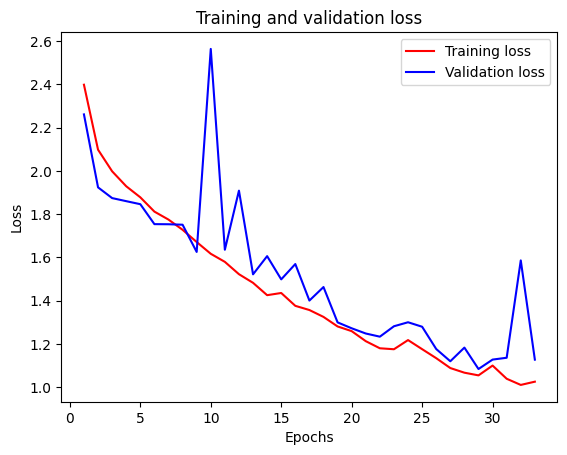

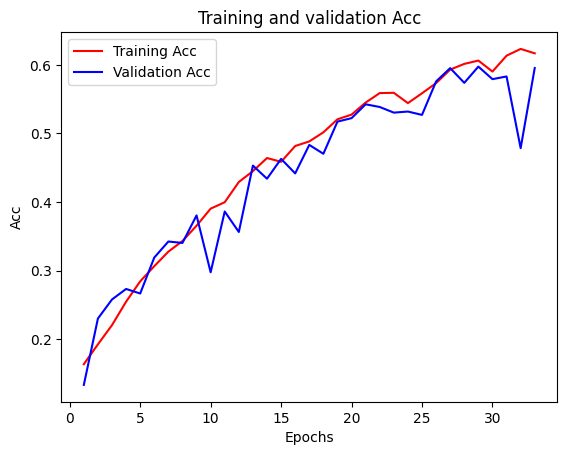

In [21]:
plot_results(history)

### Custom Model 2

In [22]:
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
# Add a batch normalization layer
model.add(BatchNormalization())
# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add a second batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a third batch normalization layer
model.add(BatchNormalization())
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a fourth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a fifth batch normalization layer
model.add(BatchNormalization())
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a sixth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())
# Add a dense layer with 256 neurons and relu activation function
model.add(Dense(256, activation='relu'))
# Add a seventh batch normalization layer
model.add(BatchNormalization())
# Add a dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(7, activation='softmax'))

In [23]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=64,img_size=(48,48),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=False)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_11 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 44, 44, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0   

None

In [24]:
history = fit_model(model=model,batch_size=64,train_generator=train_generator,val_generator=val_generator,
                   epochs=100,filepath='Custom_model2.h5')

Epoch 1/100
358/358 [==============================] - ETA: 0s - loss: 2.8105 - categorical_accuracy: 0.1830 - auc: 0.5495
Epoch 1: val_loss improved from inf to 2.01202, saving model to Custom_model2.h5
358/358 [==============================] - 21s 53ms/step - loss: 2.8105 - categorical_accuracy: 0.1830 - auc: 0.5495 - val_loss: 2.0120 - val_categorical_accuracy: 0.1721 - val_auc: 0.5953
Epoch 2/100
358/358 [==============================] - ETA: 0s - loss: 2.4226 - categorical_accuracy: 0.2213 - auc: 0.5957
Epoch 2: val_loss improved from 2.01202 to 1.82322, saving model to Custom_model2.h5
358/358 [==============================] - 18s 49ms/step - loss: 2.4226 - categorical_accuracy: 0.2213 - auc: 0.5957 - val_loss: 1.8232 - val_categorical_accuracy: 0.2877 - val_auc: 0.6733
Epoch 3/100
357/358 [============================>.] - ETA: 0s - loss: 2.2060 - categorical_accuracy: 0.2634 - auc: 0.6371
Epoch 3: val_loss improved from 1.82322 to 1.80461, saving model to Custom_model2.h5
35

Epoch 22/100
357/358 [============================>.] - ETA: 0s - loss: 1.2343 - categorical_accuracy: 0.5338 - auc: 0.8696
Epoch 22: val_loss improved from 1.21691 to 1.20836, saving model to Custom_model2.h5
358/358 [==============================] - 18s 51ms/step - loss: 1.2340 - categorical_accuracy: 0.5339 - auc: 0.8697 - val_loss: 1.2084 - val_categorical_accuracy: 0.5446 - val_auc: 0.8752
Epoch 23/100
358/358 [==============================] - ETA: 0s - loss: 1.2157 - categorical_accuracy: 0.5411 - auc: 0.8736
Epoch 23: val_loss improved from 1.20836 to 1.19886, saving model to Custom_model2.h5
358/358 [==============================] - 18s 51ms/step - loss: 1.2157 - categorical_accuracy: 0.5411 - auc: 0.8736 - val_loss: 1.1989 - val_categorical_accuracy: 0.5451 - val_auc: 0.8779
Epoch 24/100
357/358 [============================>.] - ETA: 0s - loss: 1.2042 - categorical_accuracy: 0.5473 - auc: 0.8763
Epoch 24: val_loss improved from 1.19886 to 1.17809, saving model to Custom_mo

358/358 [==============================] - ETA: 0s - loss: 1.0184 - categorical_accuracy: 0.6176 - auc: 0.9127
Epoch 43: val_loss did not improve from 1.05947
358/358 [==============================] - 18s 51ms/step - loss: 1.0184 - categorical_accuracy: 0.6176 - auc: 0.9127 - val_loss: 1.0691 - val_categorical_accuracy: 0.5976 - val_auc: 0.9041
Epoch 44/100
357/358 [============================>.] - ETA: 0s - loss: 1.0105 - categorical_accuracy: 0.6219 - auc: 0.9142
Epoch 44: val_loss did not improve from 1.05947
358/358 [==============================] - 18s 50ms/step - loss: 1.0103 - categorical_accuracy: 0.6222 - auc: 0.9143 - val_loss: 1.0667 - val_categorical_accuracy: 0.5955 - val_auc: 0.9047
Epoch 45/100
358/358 [==============================] - ETA: 0s - loss: 1.0031 - categorical_accuracy: 0.6232 - auc: 0.9154
Epoch 45: val_loss improved from 1.05947 to 1.05189, saving model to Custom_model2.h5
358/358 [==============================] - 18s 49ms/step - loss: 1.0031 - categor

357/358 [============================>.] - ETA: 0s - loss: 0.7693 - categorical_accuracy: 0.7173 - auc: 0.9501
Epoch 87: val_loss did not improve from 1.00484
358/358 [==============================] - 17s 48ms/step - loss: 0.7694 - categorical_accuracy: 0.7171 - auc: 0.9501 - val_loss: 1.0584 - val_categorical_accuracy: 0.6299 - val_auc: 0.9121
Epoch 88/100
358/358 [==============================] - ETA: 0s - loss: 0.7711 - categorical_accuracy: 0.7136 - auc: 0.9498
Epoch 88: val_loss did not improve from 1.00484
358/358 [==============================] - 18s 49ms/step - loss: 0.7711 - categorical_accuracy: 0.7136 - auc: 0.9498 - val_loss: 1.0460 - val_categorical_accuracy: 0.6345 - val_auc: 0.9148
Epoch 89/100
357/358 [============================>.] - ETA: 0s - loss: 0.7578 - categorical_accuracy: 0.7214 - auc: 0.9516
Epoch 89: val_loss did not improve from 1.00484
358/358 [==============================] - 18s 50ms/step - loss: 0.7579 - categorical_accuracy: 0.7214 - auc: 0.9515 - 

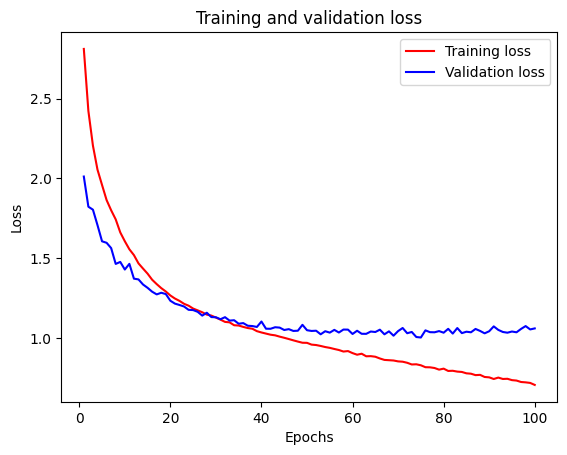

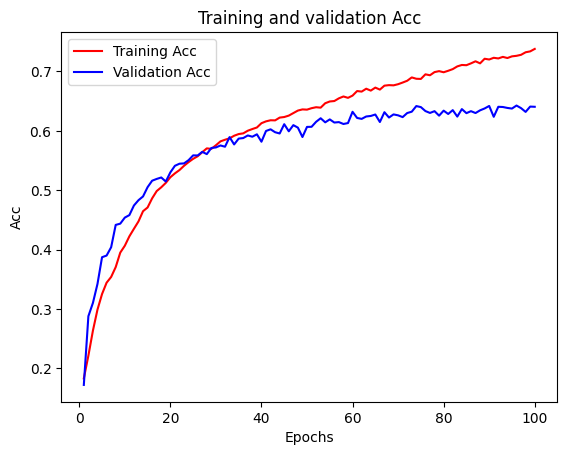

In [25]:
plot_results(history)

### Resnet50 Model Training

In [26]:
from keras.applications import ResNet50

In [27]:
resnet50 = ResNet50(include_top=False,input_shape=(224,224,3))
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

x = Dense(len(df),activation='softmax')(x)
model = Model(inputs=resnet50.input,outputs=x)

for layer in resnet50.layers:
    layer.trainable=False

In [28]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=32,img_size=(224,224),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=False,
                                                                  color_mode='rgb')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                 

 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
          

 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

None

In [29]:
history = fit_model(model=model,batch_size=32,train_generator=train_generator,val_generator=val_generator,
                   filepath='Resnet50_model.h5')

Epoch 1/25
717/717 [==============================] - ETA: 0s - loss: 1.9155 - categorical_accuracy: 0.2105 - auc: 0.6142
Epoch 1: val_loss improved from inf to 1.80652, saving model to Resnet50_model.h5
717/717 [==============================] - 205s 282ms/step - loss: 1.9155 - categorical_accuracy: 0.2105 - auc: 0.6142 - val_loss: 1.8065 - val_categorical_accuracy: 0.2519 - val_auc: 0.6474
Epoch 2/25
717/717 [==============================] - ETA: 0s - loss: 1.8554 - categorical_accuracy: 0.2147 - auc: 0.6249
Epoch 2: val_loss improved from 1.80652 to 1.80261, saving model to Resnet50_model.h5
717/717 [==============================] - 200s 279ms/step - loss: 1.8554 - categorical_accuracy: 0.2147 - auc: 0.6249 - val_loss: 1.8026 - val_categorical_accuracy: 0.2519 - val_auc: 0.6561
Epoch 3/25
717/717 [==============================] - ETA: 0s - loss: 1.8364 - categorical_accuracy: 0.2283 - auc: 0.6315
Epoch 3: val_loss improved from 1.80261 to 1.80168, saving model to Resnet50_model.h

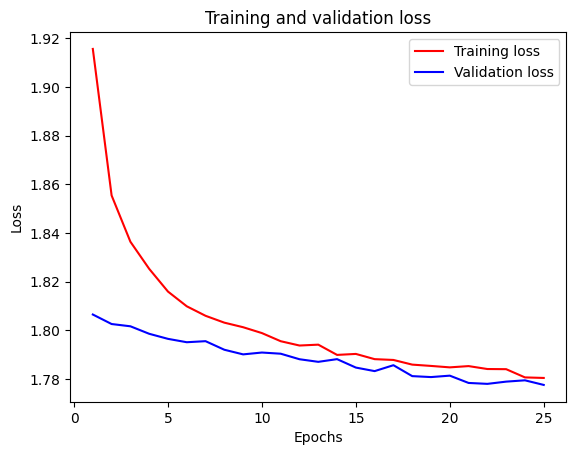

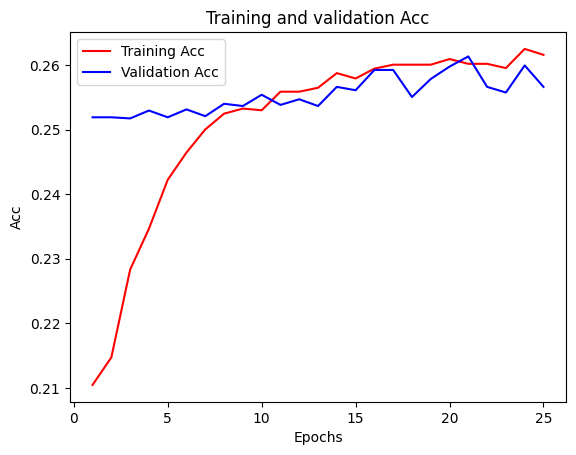

In [30]:
plot_results(history)

### Custom Model 3

In [16]:
model=keras.Sequential()

model.add(keras.layers.Convolution2D(16,3,activation='relu',input_shape=(48, 48,1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(32,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(32, 3, activation='relu'))                           
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Convolution2D(64,5,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())                        

model.add(keras.layers.Convolution2D(128,5,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(256,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(256,5,activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(128,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(32,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(32))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(7))
model.add(keras.layers.Activation('softmax'))

In [17]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=64,img_size=(48,48),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=True)

Found 25410 images belonging to 7 classes.
Found 6351 images belonging to 7 classes.
Found 7955 images belonging to 7 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 46, 46, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                             

None

In [33]:
history = fit_model(model=model,batch_size=64,train_generator=train_generator,val_generator=val_generator,epochs=100,
                   filepath='Custom_model3.h5')

Epoch 1/100
397/397 [==============================] - ETA: 0s - loss: 2.1950 - categorical_accuracy: 0.1861 - auc: 0.5533
Epoch 1: val_loss improved from inf to 1.91756, saving model to Custom_model3.h5
397/397 [==============================] - 39s 85ms/step - loss: 2.1950 - categorical_accuracy: 0.1861 - auc: 0.5533 - val_loss: 1.9176 - val_categorical_accuracy: 0.2300 - val_auc: 0.5877
Epoch 2/100
397/397 [==============================] - ETA: 0s - loss: 1.9657 - categorical_accuracy: 0.2379 - auc: 0.6124
Epoch 2: val_loss improved from 1.91756 to 1.83325, saving model to Custom_model3.h5
397/397 [==============================] - 33s 83ms/step - loss: 1.9657 - categorical_accuracy: 0.2379 - auc: 0.6124 - val_loss: 1.8332 - val_categorical_accuracy: 0.2674 - val_auc: 0.6523
Epoch 3/100
397/397 [==============================] - ETA: 0s - loss: 1.8851 - categorical_accuracy: 0.2778 - auc: 0.6508
Epoch 3: val_loss improved from 1.83325 to 1.75264, saving model to Custom_model3.h5
39

Epoch 22/100
397/397 [==============================] - ETA: 0s - loss: 1.1369 - categorical_accuracy: 0.5802 - auc: 0.8903
Epoch 22: val_loss did not improve from 1.05469
397/397 [==============================] - 33s 84ms/step - loss: 1.1369 - categorical_accuracy: 0.5802 - auc: 0.8903 - val_loss: 1.0628 - val_categorical_accuracy: 0.5950 - val_auc: 0.9046
Epoch 23/100
397/397 [==============================] - ETA: 0s - loss: 1.0562 - categorical_accuracy: 0.6062 - auc: 0.9057
Epoch 23: val_loss improved from 1.05469 to 1.04512, saving model to Custom_model3.h5
397/397 [==============================] - 34s 85ms/step - loss: 1.0562 - categorical_accuracy: 0.6062 - auc: 0.9057 - val_loss: 1.0451 - val_categorical_accuracy: 0.6098 - val_auc: 0.9081
Epoch 24/100
397/397 [==============================] - ETA: 0s - loss: 1.0295 - categorical_accuracy: 0.6216 - auc: 0.9108
Epoch 24: val_loss did not improve from 1.04512
397/397 [==============================] - 33s 84ms/step - loss: 1.0

Epoch 44/100
397/397 [==============================] - ETA: 0s - loss: 0.8053 - categorical_accuracy: 0.7028 - auc: 0.9457
Epoch 44: val_loss did not improve from 0.92748
397/397 [==============================] - 45s 113ms/step - loss: 0.8053 - categorical_accuracy: 0.7028 - auc: 0.9457 - val_loss: 0.9322 - val_categorical_accuracy: 0.6605 - val_auc: 0.9289
Epoch 45/100
397/397 [==============================] - ETA: 0s - loss: 0.7916 - categorical_accuracy: 0.7078 - auc: 0.9476
Epoch 45: val_loss did not improve from 0.92748
397/397 [==============================] - 44s 112ms/step - loss: 0.7916 - categorical_accuracy: 0.7078 - auc: 0.9476 - val_loss: 0.9340 - val_categorical_accuracy: 0.6583 - val_auc: 0.9294
Epoch 46/100
397/397 [==============================] - ETA: 0s - loss: 0.7770 - categorical_accuracy: 0.7167 - auc: 0.9494
Epoch 46: val_loss did not improve from 0.92748
397/397 [==============================] - 44s 112ms/step - loss: 0.7770 - categorical_accuracy: 0.7167 

Epoch 67/100
397/397 [==============================] - ETA: 0s - loss: 0.5417 - categorical_accuracy: 0.8038 - auc: 0.9750
Epoch 67: val_loss did not improve from 0.92190
397/397 [==============================] - 33s 83ms/step - loss: 0.5417 - categorical_accuracy: 0.8038 - auc: 0.9750 - val_loss: 0.9954 - val_categorical_accuracy: 0.6747 - val_auc: 0.9278
Epoch 68/100
397/397 [==============================] - ETA: 0s - loss: 0.5420 - categorical_accuracy: 0.8058 - auc: 0.9748
Epoch 68: val_loss did not improve from 0.92190
397/397 [==============================] - 33s 83ms/step - loss: 0.5420 - categorical_accuracy: 0.8058 - auc: 0.9748 - val_loss: 0.9872 - val_categorical_accuracy: 0.6771 - val_auc: 0.9282
Epoch 69/100
397/397 [==============================] - ETA: 0s - loss: 0.5285 - categorical_accuracy: 0.8101 - auc: 0.9760
Epoch 69: val_loss did not improve from 0.92190
397/397 [==============================] - 33s 83ms/step - loss: 0.5285 - categorical_accuracy: 0.8101 - a

Epoch 90/100
397/397 [==============================] - ETA: 0s - loss: 0.6042 - categorical_accuracy: 0.7888 - auc: 0.9682
Epoch 90: val_loss did not improve from 0.92190
397/397 [==============================] - 44s 110ms/step - loss: 0.6042 - categorical_accuracy: 0.7888 - auc: 0.9682 - val_loss: 1.1073 - val_categorical_accuracy: 0.6558 - val_auc: 0.9190
Epoch 91/100
397/397 [==============================] - ETA: 0s - loss: 0.5180 - categorical_accuracy: 0.8145 - auc: 0.9764
Epoch 91: val_loss did not improve from 0.92190
397/397 [==============================] - 44s 110ms/step - loss: 0.5180 - categorical_accuracy: 0.8145 - auc: 0.9764 - val_loss: 1.0633 - val_categorical_accuracy: 0.6722 - val_auc: 0.9241
Epoch 92/100
397/397 [==============================] - ETA: 0s - loss: 0.4302 - categorical_accuracy: 0.8479 - auc: 0.9837
Epoch 92: val_loss did not improve from 0.92190
397/397 [==============================] - 43s 109ms/step - loss: 0.4302 - categorical_accuracy: 0.8479 

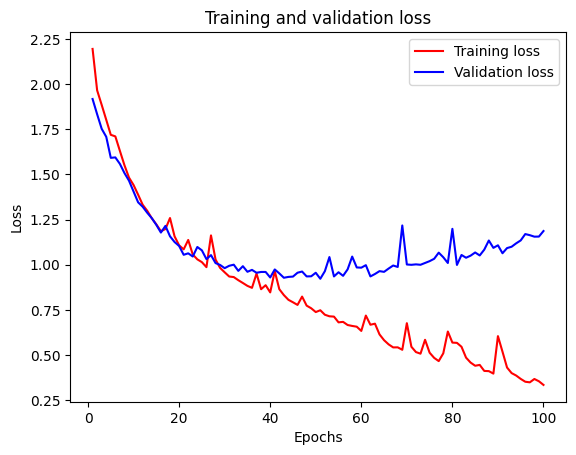

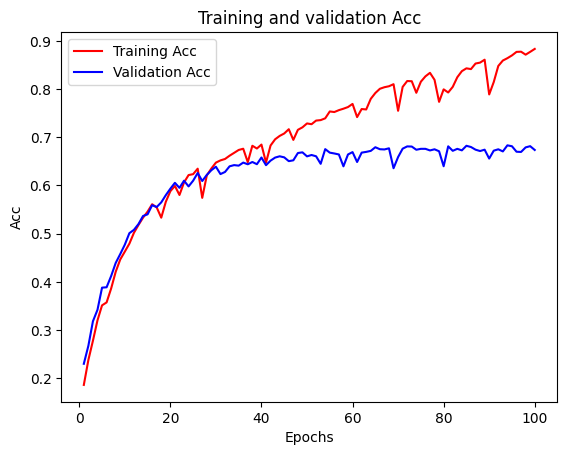

In [34]:
plot_results(history)

### Load model

In [18]:
load_model = keras.models.load_model('Custom_model3.h5')

### Evaluation

In [19]:
# Evaluate on Public Test Data
test_scores = load_model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Public Test Accuracy", test_scores[1]*100))

7955/7955 [==============================] - 69s 7ms/step - loss: 1.0498 - categorical_accuracy: 0.6430 - auc: 0.9143
Evaluate Public Test Accuracy: 64.30%


In [33]:
generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory='./live/',target_size=(48,48),batch_size=1,shuffle=False,color_mode='grayscale')

Found 1 images belonging to 1 classes.


In [40]:
# Predictions

predict = load_model.predict(generator)

labels = test_generator.classes
int(predict.argmax(axis=1))
#conf_mat = tf.math.confusion_matrix(labels=labels,predictions=predict.argmax(axis=1),num_classes=7)

#print(conf_mat)

1/1 [==============================] - 0s 48ms/step


2

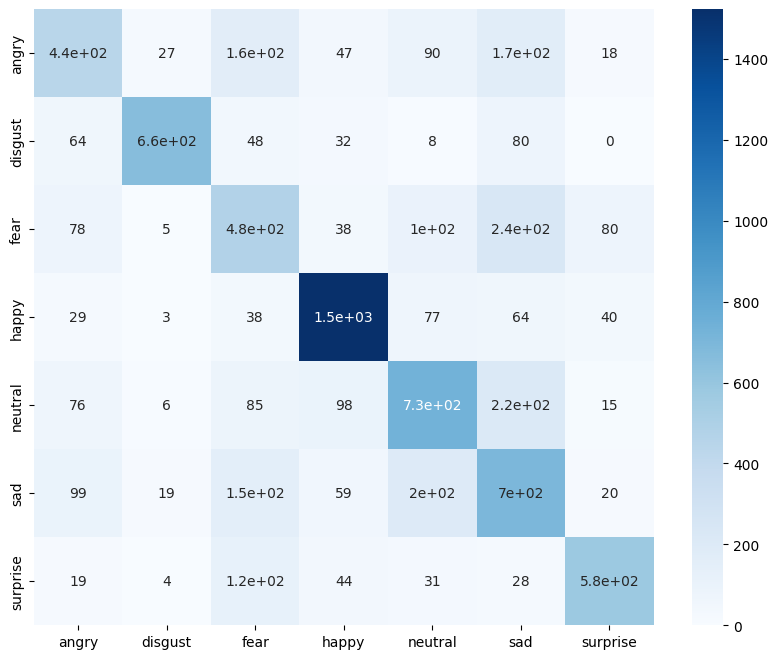

In [68]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,xticklabels=df.Emotions,yticklabels=df.Emotions,cmap='Blues')
plt.show()

### Model Architecture

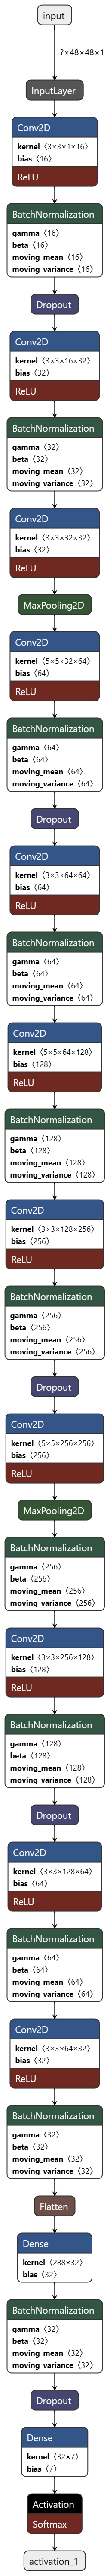